In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip -q "UCI HAR Dataset.zip"
# we load the dataset

--2025-03-02 06:30:56--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip     [     <=>            ]  58.17M  3.65MB/s    in 9.5s    

2025-03-02 06:31:07 (6.13 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314]



In [2]:
import numpy as np

def load_data(path, prefix1, prefix2):
    x = np.loadtxt(f'{path}/{prefix1}_x{prefix2}.txt')
    y = np.loadtxt(f'{path}/{prefix1}_y{prefix2}.txt')
    z = np.loadtxt(f'{path}/{prefix1}_z{prefix2}.txt')
    return np.stack([x, y, z], axis=-1)

# training data
train_body_acc = load_data('UCI HAR Dataset/train/Inertial Signals', 'body_acc', '_train')
train_body_gyro = load_data('UCI HAR Dataset/train/Inertial Signals', 'body_gyro', '_train')
X_train_raw = np.concatenate([train_body_acc, train_body_gyro], axis=-1)

#testing data
test_body_acc = load_data('UCI HAR Dataset/test/Inertial Signals', 'body_acc', '_test')
test_body_gyro = load_data('UCI HAR Dataset/test/Inertial Signals', 'body_gyro', '_test')
X_test_raw = np.concatenate([test_body_acc, test_body_gyro], axis=-1)

y_train = np.loadtxt('UCI HAR Dataset/train/y_train.txt') - 1
y_test = np.loadtxt('UCI HAR Dataset/test/y_test.txt') - 1
 # Convert to 0-based

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten

# normalize data for smooth and stable training
mean, std = X_train_raw.mean(axis=(0,1)), X_train_raw.std(axis=(0,1))
X_train_norm = (X_train_raw - mean) / (std + 1e-8)
X_test_norm = (X_test_raw - mean) / (std + 1e-8)

In [4]:
!pip install tsfel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.6 MB/s eta 0:00:00


In [5]:
import tsfel
from tqdm import tqdm
import pandas as pd
from sklearn.impute import SimpleImputer


cfg = tsfel.get_features_by_domain()

def bulk_feature_extraction(data):
    reshaped_data = data.reshape(-1, 6)

    time = np.arange(len(reshaped_data)) / 50  # 50Hz sampling rate

    features = tsfel.time_series_features_extractor(
        cfg,
        reshaped_data,
        fs=50,
        window_size=128,
        overlap=0,
        verbose=1
    )
    return features.values.reshape(len(data), -1)


print("Processing training data-")
X_train_tsfel = bulk_feature_extraction(X_train_raw)

print("Processing test data-")
X_test_tsfel = bulk_feature_extraction(X_test_raw)


imputer = SimpleImputer(strategy='mean')
X_train_tsfel = imputer.fit_transform(X_train_tsfel)
X_test_tsfel = imputer.transform(X_test_tsfel)


np.save('X_train_tsfel_1.npy', X_train_tsfel)
np.save('X_test_tsfel_1.npy', X_test_tsfel)

Processing training data-


Processing test data-


In [6]:
# Now we load the original precomputed features from UCI HAR dataset
X_train_orig = np.loadtxt('UCI HAR Dataset/train/X_train.txt')
X_test_orig = np.loadtxt('UCI HAR Dataset/test/X_test.txt')

#we already loaded the original labels earlier

In [7]:
from sklearn.preprocessing import StandardScaler

# Scaling original features (TSFEL features already scaled)
scaler = StandardScaler()
X_train_orig_scaled = scaler.fit_transform(X_train_orig)
X_test_orig_scaled = scaler.transform(X_test_orig)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

def train_evaluate(model, X_train, X_test, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))

# Train on TSFEL features
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(kernel='rbf'),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

for name, model in models.items():
    train_evaluate(model, X_train_tsfel, X_test_tsfel, f"{name} (TSFEL)")

# Train on Original Features
for name, model in models.items():
    train_evaluate(model, X_train_orig_scaled, X_test_orig_scaled, f"{name} (Original)")


Random Forest (TSFEL) Performance:
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       496
         1.0       0.95      0.97      0.96       471
         2.0       0.96      0.88      0.92       420
         3.0       0.86      0.82      0.84       491
         4.0       0.85      0.94      0.89       532
         5.0       0.93      0.88      0.90       537

    accuracy                           0.91      2947
   macro avg       0.92      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947


SVM (TSFEL) Performance:
              precision    recall  f1-score   support

         0.0       0.77      0.81      0.79       496
         1.0       0.71      0.81      0.75       471
         2.0       0.88      0.71      0.79       420
         3.0       0.70      0.71      0.71       491
         4.0       0.77      0.76      0.76       532
         5.0       0.78      0.78      0.78       537

    accuracy   

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression (TSFEL) Performance:
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92       496
         1.0       0.93      0.92      0.92       471
         2.0       0.93      0.85      0.89       420
         3.0       0.76      0.74      0.75       491
         4.0       0.80      0.84      0.82       532
         5.0       0.83      0.82      0.83       537

    accuracy                           0.85      2947
   macro avg       0.86      0.85      0.85      2947
weighted avg       0.85      0.85      0.85      2947


Random Forest (Original) Performance:
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.93       496
         1.0       0.89      0.91      0.90       471
         2.0       0.95      0.84      0.90       420
         3.0       0.91      0.91      0.91       491
         4.0       0.92      0.91      0.92       532
         5.0       1.00      1.00      1.00       5

# **DEEP LEARNING METHODS: LSTM, CNN, CNN-LSTM. **
on extracted features data from raw accelerometer and gyrometer readings. (NOT TSFEL)



In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten

# using raw data (X_train_raw, X_test_raw)
# Normalize
mean, std = X_train_raw.mean(axis=(0,1)), X_train_raw.std(axis=(0,1))
X_train_norm = (X_train_raw - mean) / (std + 1e-8)
X_test_norm = (X_test_raw - mean) / (std + 1e-8)

# LSTM Model
model_lstm = Sequential([
    LSTM(64, input_shape=(128, 6)),
    Dense(32, activation='relu'),
    Dense(6, activation='softmax')
])
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#  CNN Model
model_cnn = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(128, 6)),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])
model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Hybrid CNN-LSTM Model
model_cnn_lstm = Sequential([
    # CNN Layers
    Conv1D(64, 3, activation='relu', input_shape=(128, 6)),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),

    # LSTM Layer
    LSTM(64, return_sequences=False),

    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])
model_cnn_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
history_lstm = model_lstm.fit(X_train_norm, y_train, epochs=15, batch_size=64, validation_split=0.2)
history_cnn = model_cnn.fit(X_train_norm, y_train, epochs=15, batch_size=64, validation_split=0.2)
history_cnn_lstm = model_cnn_lstm.fit(X_train_norm, y_train, epochs=20,batch_size=64,validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2772 - loss: 1.6390 - val_accuracy: 0.4099 - val_loss: 1.0728
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4684 - loss: 0.9918 - val_accuracy: 0.5588 - val_loss: 0.8084
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5945 - loss: 0.7619 - val_accuracy: 0.6179 - val_loss: 0.6492
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6083 - loss: 0.6728 - val_accuracy: 0.6111 - val_loss: 0.6342
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6348 - loss: 0.6262 - val_accuracy: 0.6193 - val_loss: 0.6324
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6390 - loss: 0.6233 - val_accuracy: 0.6159 - val_loss: 0.6454
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6486 - loss: 0.6231 - val_accuracy: 0.6173 - val_loss: 0.6757
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6278 - loss: 0.6458 - val_accuracy: 0.6173 - val_loss

RESULTS OF DEEP LEARNING MODELS


In [15]:
#evaluate
lstm_acc = model_lstm.evaluate(X_test_norm, y_test, verbose=0)[1]
cnn_acc = model_cnn.evaluate(X_test_norm, y_test, verbose=0)[1]
cnn_lstm_acc = model_cnn_lstm.evaluate(X_test_norm, y_test, verbose=0)[1]

print(f"LSTM Test Accuracy: {lstm_acc:.3f}")
print(f"CNN Test Accuracy: {cnn_acc:.3f}")
print(f"CNN-LSTM Test Accuracy: {cnn_lstm_acc:.3f}")

LSTM Test Accuracy: 0.641
CNN Test Accuracy: 0.865
CNN-LSTM Test Accuracy: 0.915


In [19]:
from sklearn.metrics import accuracy_score

# 1. Evaluate ML models with TSFEL features
results = []
for name, model in models.items():
    # Train on TSFEL features
    model.fit(X_train_tsfel, y_train)
    y_pred = model.predict(X_test_tsfel)
    acc = accuracy_score(y_test, y_pred)
    results.append({'Model': f'{name} (TSFEL)', 'Accuracy': acc})

    # Train on Original features
    model.fit(X_train_orig_scaled, y_train)
    y_pred = model.predict(X_test_orig_scaled)
    acc = accuracy_score(y_test, y_pred)
    results.append({'Model': f'{name} (Original)', 'Accuracy': acc})

# 2. Evaluate DL models
results.extend([
    {'Model': 'LSTM', 'Accuracy': lstm_acc},
    {'Model': '1D CNN', 'Accuracy': cnn_acc},
    {'Model': 'CNN-LSTM', 'Accuracy':cnn_lstm_acc}
])

results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)
print(results_df) #print results

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                            Model  Accuracy
5  Logistic Regression (Original)  0.956566
3                  SVM (Original)  0.952155
1        Random Forest (Original)  0.926366
8                        CNN-LSTM  0.914829
0           Random Forest (TSFEL)  0.910078
7                          1D CNN  0.865287
4     Logistic Regression (TSFEL)  0.853071
2                     SVM (TSFEL)  0.763488
6                            LSTM  0.640991


In [20]:
results_df.to_csv('model_comparison_allmodels.csv', index=False)

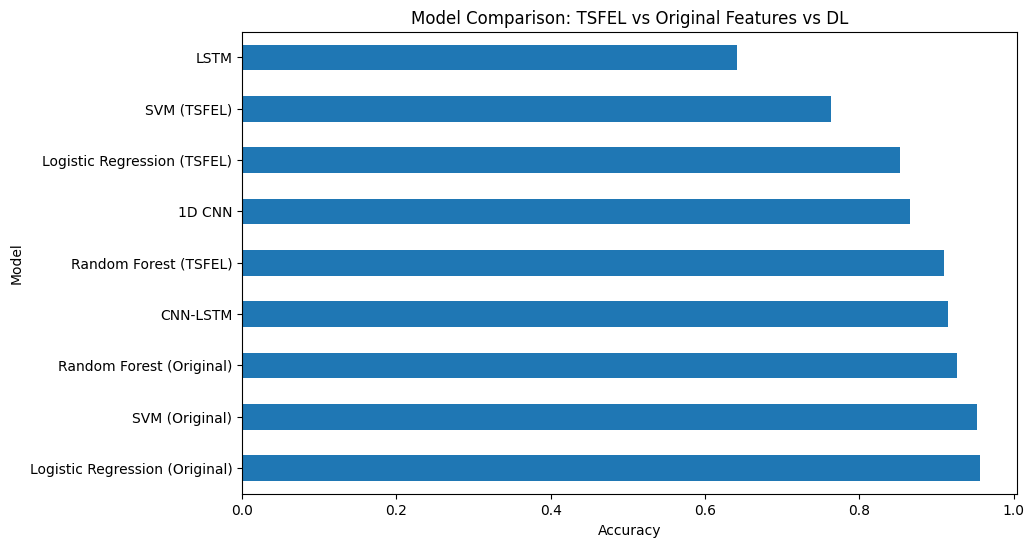

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
results_df.set_index('Model')['Accuracy'].plot(kind='barh')
plt.title('Model Comparison: TSFEL vs Original Features vs DL')
plt.xlabel('Accuracy')
plt.show()